In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import matplotlib.cm as cm
from scipy.misc import imresize
import cv2
import pandas as pd
import scipy.io as io
import os

In [6]:
def data_extraction(path_left, path_right):
    img_path_left = glob(path_left + '/*.jpg')
    img_path_right = glob(path_right + '/*.jpg')
    img_path_left.sort()
    img_path_right.sort()
    data_right = []
    data_left = []
    for i in range(len(img_path_left)):
        img_left = cv2.imread(img_path_left[i], 0)
        img_right = cv2.imread(img_path_right[i], 0)
        data_left.append(img_left)
        data_right.append(img_right)
    return [data_right, data_left]

In [7]:
def label_extraction(path, screen_path):
    txt = pd.read_csv(path, sep = ' ', header= None)
    screen = io.loadmat(screen_path)
    df_anno = pd.DataFrame(txt)
    data_frame = pd.DataFrame()
    data_frame['Screen_x'] = df_anno[:][24] / screen['width_pixel'][0][0]
    data_frame['Screen_y'] = df_anno[:][25] / screen['height_pixel'][0][0]
    return data_frame

In [8]:
image_path_right = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Our_data_right/*/*/')
image_path_left = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Our_data_left/*/*/')
image_path_left.sort()
image_path_right.sort()

In [9]:
def path_optimization(day_list, path):
    all_path = []
    cnt = 0
    for i in range(len(day_list)): # 15번 
        temp = []
        for j in range(day_list[i]):
            temp.append(path[cnt])
            cnt += 1
        all_path.append(temp)
    return all_path

day_list = [39, 69, 39, 65, 25, 38, 62, 56, 47, 20, 16, 19, 7, 12, 7]  
image_path_left_op = path_optimization(day_list, image_path_left)
image_path_right_op = path_optimization(day_list, image_path_right)

label_path = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Original/*/*/annotation.txt') # 521개
label_path.sort()
label_path = path_optimization(day_list, label_path)
#label_path = path_optimzation(glob('C:/MPIIGaze/MPIIGaze/Data/Original/*/*/annotation.txt'))
screen_size_path = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Original/*/Calibration/screenSize.mat') # 15개

In [10]:
for i in range(15): # 총 15명
    data = [] # 사람별로 나눈 데이터
    label = [] # 사람별로 나눈 라벨   
    for j in range(day_list[i]): # 각 사람에 맞는 day만큼
        data.append(data_extraction(image_path_left_op[i][j], image_path_right_op[i][j]))
        label.append(label_extraction(label_path[i][j], screen_size_path[i]))
    exec('p%d_data = data' % (i))
    exec('p%d_label = label' % (i))

In [11]:
def make_dataset_img_label(image_shape, label_shape, data_list, label_list):
    length = len(data_list[0])
    left_img = np.zeros([length,image_shape])
    right_img = np.zeros([length,image_shape])
    label = np.zeros([length,label_shape])
    for n in range(length):
        left_img[n, :] = data_list[1][n].reshape(image_shape)      
        right_img[n, :] = data_list[0][n].reshape(image_shape)
        label[n, :] = [label_list['Screen_x'][n], label_list['Screen_y'][n]]
        
    return right_img, left_img, label

In [12]:
Batch_RE_img_data = []
Batch_LE_img_data = []
#Batch_LE_gaze_data = []
#Batch_RE_gaze_data = [] 
#Batch_LE_pose_data = []
#Batch_RE_pose_data = []
Batch_label = []
for i in range(15):
    for j in range(day_list[i]): #days list in Data  po -> 39days  ..
        exec('RE_img_data, LE_img_data, dataset_label = make_dataset_img_label(36 * 60, 2, p{0}_data[{1}], p{2}_label[{3}])'
             .format(i, j, i, j))
        Batch_RE_img_data.append(RE_img_data)
        Batch_LE_img_data.append(LE_img_data)
#         Batch_LE_gaze_data.append(LE_gaze_data)
#         Batch_RE_gaze_data.append(RE_gaze_data)
#         Batch_LE_pose_data.append(LE_pose_data)
#         Batch_RE_pose_data.append(RE_pose_data)
        Batch_label.append(dataset_label)

# Make graph for eye images

In [26]:
def model_for_image(param):
    X_img, keep_prob, name, my_batch_norm_layer = param[0], param[1], param[2], param[3]
    with tf.name_scope("Image_layer_1_" + name) as scope:
        W1 = tf.Variable(tf.random_normal([4, 4, 1, 20], stddev=0.01))
        L1 = tf.nn.conv2d(X_img, W1, strides=[1, 2, 2, 1], padding='SAME')
        bn1 = my_batch_norm_layer(L1)
        bn1_act = tf.nn.elu(bn1)
        
    with tf.name_scope("Image_layer_2_" + name) as scope:
        W2 = tf.Variable(tf.random_normal([2, 2, 20, 40], stddev=0.01))
        L2 = tf.nn.conv2d(bn1_act, W2, strides=[1, 2, 2, 1], padding='SAME')
        bn2 = my_batch_norm_layer(L2)
        bn2_act = tf.nn.elu(bn2)
        L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
        L2_flat = tf.reshape(L2, [-1, 5 * 8 * 40])
    
    with tf.name_scope("Image_layer_3_" + name) as scope:
        W3 = tf.get_variable("W3_"+name ,shape= [400, 256],
                             initializer=tf.contrib.layers.variance_scaling_initializer())
        b3 = tf.Variable(tf.random_normal([256]))
        L3 = tf.nn.relu(tf.matmul(L2_flat, W3) + b3)
        L3 = tf.nn.dropout(L3, keep_prob= keep_prob)

    with tf.name_scope("Image_layer_4_" + name) as scope:
        W4 = tf.get_variable("W4_"+name ,shape= [256, 128],
                             initializer=tf.contrib.layers.variance_scaling_initializer())
        b4 = tf.Variable(tf.random_normal([128]))
        L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
        L4 = tf.nn.dropout(L4, keep_prob= keep_prob)

    with tf.name_scope("Image_layer_5_" + name) as scope:
        W5 = tf.get_variable("W5_"+name ,shape= [128, 64],
                             initializer=tf.contrib.layers.variance_scaling_initializer())
        b5 = tf.Variable(tf.random_normal([64]))
        logit = tf.matmul(L4, W5) + b5
    return logit

In [32]:
temp = keras.Sequential()
temp_2 = keras.Sequential()

In [ ]:
def model_for_image_2(param, model = model_graph):
    X_img, keep_prob, name = param[0], param[1], param[2]
    with model_graph.as_default():
        with tf.name_scope(name +'_image_layers')
            conv_1 = Conv2D(20, [7, 7], strides = [1, 1],
                   activation = 'elu', padding='same', name= 'conv_1_'+name)(X_img)
            bn_1 = BatchNormalization(name= 'bn_1_'+name)(conv_1)
            
            conv_2 = Conv2D(20, [2, 2], strides = [2, 2],
                    activation = 'elu', padding='same', name= 'conv_2'+name)(bn_1)
            bn_2 = BatchNormalization(name= 'bn_2_'+name)(conv_2)
            
            conv_3 = Conv2D(40, [5, 5], strides = [1, 1],
                   activation = 'elu', padding='valid',name= 'conv_3'+name)(bn_2)
            bn_3 = BatchNormalization(name= 'bn_3_'+name)(conv_3)
            
            conv_4 =Conv2D(40, [2, 2], strides = [2, 2],
                    activation = 'elu', padding='same', name = 'conv_4'+name)(bn_3)
            bn_4 = BatchNormalization(name= 'bn_4_'+name)(conv_4)
            
            conv_5 = Conv2D(80, [6, 6], strides = [1, 1],
                            activation = 'elu', padding='valid')
            bn_5 = BatchNormalization(name= 'bn_4_'+name)(conv_5)
            Dense(units= 280, input_dim = 560, activation= 'elu')
            Dropout(keep_prob)
            Dense(units= 100, input_dim = 280, activation= 'elu')
    
    return logit

# Integrate the Image layer

In [27]:
def model(LE_param, RE_param):
    
    LE = model_for_image(LE_param)
    RE = model_for_image(RE_param)
    with tf.name_scope("Layer_Image_merged_1") as scope:
        LE_W_img = tf.get_variable("LE_W_img" ,shape= [64, 32],
                                     initializer=tf.contrib.layers.variance_scaling_initializer())
        RE_W_img = tf.get_variable("RE_W_img" ,shape= [64, 32],
                                     initializer=tf.contrib.layers.variance_scaling_initializer())
        merged_img_b = tf.Variable(tf.random_normal([32]))
        layer_img = tf.matmul(LE, LE_W_img) + tf.matmul(RE, RE_W_img) + merged_img_b
        layer_img = tf.nn.dropout(layer_img, keep_prob= keep_prob)

    with tf.name_scope("Layer_Image_merged_2") as scope:
        img_W = tf.get_variable("img_W" ,shape= [32, 16],
                                     initializer=tf.contrib.layers.variance_scaling_initializer())
        img_b = tf.Variable(tf.random_normal([16]))
        layer2_img = tf.matmul(layer_img, img_W) + img_b
        layer2_img = tf.nn.dropout(layer2_img, keep_prob= keep_prob)

    with tf.name_scope("Layer_Image_merged_3") as scope:
        img_W2 = tf.get_variable("img_W2" ,shape= [16, 8],
                                     initializer=tf.contrib.layers.variance_scaling_initializer())
        img_b2 = tf.Variable(tf.random_normal([8]))
        layer3_img= tf.matmul(layer2_img, img_W2) + img_b2
        layer3_img = tf.nn.dropout(layer3_img, keep_prob= keep_prob)

    with tf.name_scope("Layer_Image_merged_Last") as scope:
        Final_W_img = tf.get_variable("Final_W_img" ,shape= [8, 2],
                                     initializer=tf.contrib.layers.variance_scaling_initializer())
        logits =  tf.matmul(layer3_img, Final_W_img)
    return logits

In [28]:
# with tf.name_scope("Layer_Image_merged_1") as scope:
#     LE_W_img = tf.get_variable("LE_W_img" ,shape= [64, 32],
#                              initializer=tf.contrib.layers.variance_scaling_initializer())
#     RE_W_img = tf.get_variable("RE_W_img" ,shape= [64, 32],
#                              initializer=tf.contrib.layers.variance_scaling_initializer())
    
#     merged_img_b = tf.Variable(tf.random_normal([32]))
#     layer_img = tf.matmul(LE_img, LE_W_img) + tf.matmul(RE_img, RE_W_img) + merged_img_b
#     layer_img = tf.nn.dropout(layer_img, keep_prob= keep_prob)
#     bn_merged = batch_norm_layer(layer_img)
#     bn_merged_act = tf.nn.elu(bn_merged)
    
# with tf.name_scope("Layer_Image_merged_2") as scope:
#     img_W = tf.get_variable("img_W" ,shape= [32, 16],
#                              initializer=tf.contrib.layers.variance_scaling_initializer())
#     img_b = tf.Variable(tf.random_normal([16]))
#     layer2_img = tf.matmul(bn_merged_act, img_W) + img_b
#     layer2_img = tf.nn.dropout(layer2_img, keep_prob= keep_prob)
#     bn_merged2 = batch_norm_layer(layer2_img)
#     bn_merged2_act = tf.nn.elu(bn_merged2)
    
# with tf.name_scope("Layer_Image_merged_3") as scope:
#     img_W2 = tf.get_variable("img_W2" ,shape= [16, 8],
#                              initializer=tf.contrib.layers.variance_scaling_initializer())
#     img_b2 = tf.Variable(tf.random_normal([8]))
#     layer3_img= tf.matmul(bn_merged2_act, img_W2) + img_b2
#     layer3_img = tf.nn.dropout(layer3_img, keep_prob= keep_prob)
#     bn_merged3 = batch_norm_layer(layer3_img)
#     bn_merged3_act = tf.nn.elu(bn_merged3)

# with tf.name_scope("Layer_Image_merged_Last") as scope:
# #     Final_W_img = tf.get_variable("Final_W_img" ,shape= [8, 3],
# #                              initializer= tf.contrib.layers.xavier_initializer())
# #     Final_b_img = tf.Variable(tf.random_normal([3]))
# #     Final_layer_img= tf.nn.relu(tf.matmul(layer3_img, Final_W_img) + Final_b_img)
#     Final_W_img = tf.get_variable("Final_W_img" ,shape= [8, 2],
#                              initializer=tf.contrib.layers.variance_scaling_initializer())
#     logits =  tf.matmul(layer3_img, Final_W_img)

# Define variable and make graphs using function

In [30]:
from functools import partial

tf.reset_default_graph()
#hyper parameter
training = tf.placeholder_with_default(False, shape=[], name="training")
batch_norm_momentum = 0.9
learning_rate = 0.01
Y = tf.placeholder(tf.float32, [None, 2])
keep_prob = tf.placeholder(tf.float32)

# define input
X_left = tf.placeholder(tf.float32, [None, 2160])
X_right = tf.placeholder(tf.float32, [None, 2160])
X_img_left = tf.reshape(X_left, [-1, 36, 60, 1])   
X_img_right = tf.reshape(X_right, [-1, 36, 60, 1]) 

param_left = (X_img_left, keep_prob, 'left_eye')
param_right = (X_img_right, keep_prob, 'right_eye')

CHECK_POINT_DIR = TB_SUMMARY_DIR = '../temp/graph/'
global_step = 0

In [31]:
model_graph = model(LE_param= param_left, RE_param= param_right)

W0916 18:49:27.314495 140019386353408 deprecation.py:506] From <ipython-input-26-695681a8c7b2>:7: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0916 18:49:28.441243 140019386353408 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [32]:
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.square(model_graph-Y))
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)

tf.summary.scalar("loss", cost)
summary = tf.summary.merge_all()

last_epoch = tf.Variable(0, name='last_epoch')

In [33]:
cost_graph = []

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(TB_SUMMARY_DIR)
    writer.add_graph(sess.graph)

    saver = tf.train.Saver()
    checkpoint = tf.train.get_checkpoint_state(CHECK_POINT_DIR)    
    
    if checkpoint and checkpoint.model_checkpoint_path:
        try:
            saver.restore(sess, checkpoint.model_checkpoint_path)
            print("Successfully loaded:", checkpoint.model_checkpoint_path)
        except:
            print("Error on loading old network weights")
    else:
        print("Could not find old network weights")

    start_from = sess.run(last_epoch)
    print('Learning started')
    for i in range(start_from, 450):  #Train set size
        feed_dict = {X_right: Batch_RE_img_data[i],
                    X_left: Batch_LE_img_data[i],
                    Y:Batch_label[i], keep_prob: 0.7}
        #s, _ = sess.run([summary, optimizer], feed_dict=feed_dict)
        #writer.add_summary(s, global_step=global_step)
        c= sess.run(cost,feed_dict=feed_dict)
        print('Batch_Number:{0}, Batch_cost: {1}'.format(i, c))
        save_path = saver.save(sess,'../temp/variables/model.ckpt') 
        cost_graph.append(c)
        global_step += 1
        
        print("Saving network...\n")
        sess.run(last_epoch.assign(i + 1))
        if not os.path.exists(CHECK_POINT_DIR):
            os.makedirs(CHECK_POINT_DIR)
        saver.save(sess, CHECK_POINT_DIR + "/model", global_step=j)

print('Learning Finished!')

Could not find old network weights
Learning started
Batch_Number:0, Batch_cost: 108.53499603271484
Saving network...

Batch_Number:1, Batch_cost: 103.316650390625
Saving network...

Batch_Number:2, Batch_cost: 107.00682830810547
Saving network...

Batch_Number:3, Batch_cost: 108.6179428100586
Saving network...

Batch_Number:4, Batch_cost: 108.07077026367188
Saving network...

Batch_Number:5, Batch_cost: 109.67855072021484
Saving network...

Batch_Number:6, Batch_cost: 121.95320892333984
Saving network...

Batch_Number:7, Batch_cost: 108.9684066772461
Saving network...

Batch_Number:8, Batch_cost: 109.95758056640625
Saving network...

Batch_Number:9, Batch_cost: 112.97023010253906
Saving network...

Batch_Number:10, Batch_cost: 105.72859191894531
Saving network...

Batch_Number:11, Batch_cost: 102.42217254638672
Saving network...

Batch_Number:12, Batch_cost: 109.37923431396484
Saving network...

Batch_Number:13, Batch_cost: 126.91043090820312
Saving network...

Batch_Number:14, Batch_c

Batch_Number:123, Batch_cost: 113.82056427001953
Saving network...

Batch_Number:124, Batch_cost: 123.22209167480469
Saving network...

Batch_Number:125, Batch_cost: 117.86693572998047
Saving network...

Batch_Number:126, Batch_cost: 107.95208740234375
Saving network...

Batch_Number:127, Batch_cost: 117.37590026855469
Saving network...

Batch_Number:128, Batch_cost: 108.5124282836914
Saving network...

Batch_Number:129, Batch_cost: 105.24198913574219
Saving network...

Batch_Number:130, Batch_cost: 108.68244934082031
Saving network...

Batch_Number:131, Batch_cost: 102.81598663330078
Saving network...

Batch_Number:132, Batch_cost: 108.40370178222656
Saving network...

Batch_Number:133, Batch_cost: 108.09427642822266
Saving network...

Batch_Number:134, Batch_cost: 105.42884063720703
Saving network...

Batch_Number:135, Batch_cost: 95.89186096191406
Saving network...

Batch_Number:136, Batch_cost: 110.82381439208984
Saving network...

Batch_Number:137, Batch_cost: 111.45832061767578
S

Batch_Number:244, Batch_cost: 112.02115631103516
Saving network...

Batch_Number:245, Batch_cost: 107.68020629882812
Saving network...

Batch_Number:246, Batch_cost: 102.70780944824219
Saving network...

Batch_Number:247, Batch_cost: 110.61947631835938
Saving network...

Batch_Number:248, Batch_cost: 108.7024917602539
Saving network...

Batch_Number:249, Batch_cost: 100.4928970336914
Saving network...

Batch_Number:250, Batch_cost: 106.14307403564453
Saving network...

Batch_Number:251, Batch_cost: 112.53583526611328
Saving network...

Batch_Number:252, Batch_cost: 106.94392395019531
Saving network...

Batch_Number:253, Batch_cost: 106.21456146240234
Saving network...

Batch_Number:254, Batch_cost: 101.74836730957031
Saving network...

Batch_Number:255, Batch_cost: 112.34025573730469
Saving network...

Batch_Number:256, Batch_cost: 122.74515533447266
Saving network...

Batch_Number:257, Batch_cost: 107.09293365478516
Saving network...

Batch_Number:258, Batch_cost: 110.96163940429688
S

Batch_Number:366, Batch_cost: 108.95014953613281
Saving network...

Batch_Number:367, Batch_cost: 97.29716491699219
Saving network...

Batch_Number:368, Batch_cost: 115.97102355957031
Saving network...

Batch_Number:369, Batch_cost: 107.92047119140625
Saving network...

Batch_Number:370, Batch_cost: 126.73409271240234
Saving network...

Batch_Number:371, Batch_cost: 88.37869262695312
Saving network...

Batch_Number:372, Batch_cost: 99.69733428955078
Saving network...

Batch_Number:373, Batch_cost: 100.9037094116211
Saving network...

Batch_Number:374, Batch_cost: 109.65325164794922
Saving network...

Batch_Number:375, Batch_cost: 109.55270385742188
Saving network...

Batch_Number:376, Batch_cost: 99.82965850830078
Saving network...

Batch_Number:377, Batch_cost: 90.49108123779297
Saving network...

Batch_Number:378, Batch_cost: 111.15238952636719
Saving network...

Batch_Number:379, Batch_cost: 111.10658264160156
Saving network...

Batch_Number:380, Batch_cost: 116.61859893798828
Savin

In [19]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [20]:
show_graph(tf.get_default_graph())

(0, 1)

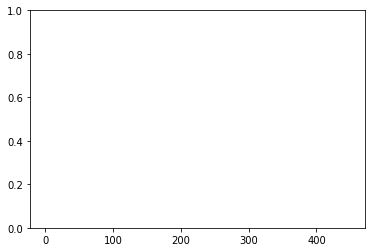

In [34]:
plt.plot(cost_graph)
plt.ylim(0,1)

In [36]:
x_data_frame = pd.DataFrame()
y_data_frame = pd.DataFrame()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(450, 521):
        predictions = model_graph.eval(feed_dict = {
                X_right: Batch_RE_img_data[i],
                X_left: Batch_LE_img_data[i],
                keep_prob: 1})
        x_data_frame = pd.concat([pd.DataFrame(predictions), x_data_frame], ignore_index= True)
        y_data_frame = pd.concat([pd.DataFrame(Batch_label[i]), y_data_frame], ignore_index= True)

In [37]:
x_data_frame

,0,1
0,-1.290645,-14.006769
1,-1.351165,-14.329849
2,-1.299284,-13.993162
3,-1.306480,-14.053202
4,-1.369119,-14.243830
5,-1.408422,-14.234203
6,-1.286169,-14.148697
7,-1.320438,-14.142910
8,-1.343582,-14.220028
9,-1.244815,-14.076307


In [ ]:
y_data_frame

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data_frame, y_data_frame, test_size=0.33, random_state=42)

In [ ]:
rnd_clf = RandomForestRegressor(random_state= 42)
rnd_clf.fit(X_train, y_train)

In [ ]:
y_pred = rnd_clf.predict(X_test)
y_pred_pd = pd.DataFrame(y_pred)

In [ ]:
y_pred_pd

In [ ]:
y_test

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test, y_pred)

In [ ]:
error

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

In [ ]:
y_pred_df = pd.DataFrame(tree_reg.predict(X_test))
y_pred_df

In [ ]:
y_test

In [ ]:
error = mean_squared_error(y_pred_df, y_test)

In [ ]:
error